<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/tim-baseline-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install pyspark -q
# !{sys.executable} -m pip install -U spacy -q
# !{sys.executable} -m spacy download en_core_web_lg -q

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 199 kB 12.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
url = 'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Train.csv'
!wget {url}

--2022-10-01 15:24:19--  https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50868407 (49M) [text/plain]
Saving to: ‘WikiLarge_Train.csv’

WikiLarge_Train.csv 100%[===================>]  48.51M   198MB/s    in 0.2s    

2022-10-01 15:24:21 (198 MB/s) - ‘WikiLarge_Train.csv’ saved [50868407/50868407]



In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

df = spark.read.csv('/content/WikiLarge_Train.csv', header=True)
df.createOrReplaceTempView('wiki')
df.printSchema()

root
 |-- original_text: string (nullable = true)
 |-- label: string (nullable = true)



In [7]:
spark.sql('SELECT * FROM wiki LIMIT 5;').show(5, 0)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|original_text                                                                                                                                                                                                                                           |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .             

In [8]:
regex1, replace1 = r'-LRB-', '('
regex2, replace2 = r'-RRB-', ')'
regex3, replace3 = r"\'\' *", ''
regex4, replace4 = r", ; *", ''
regex5, replace5 = r"; , *", ''
regex6, replace6 = r", , *", ''
regex7, replace7 = r"; ; *", ''
regex8, replace8 = r"[(] [;,-]* [)] ", ''
regex9, replace9 = r"[(] +[)] *", ''

iterable = ((regex1, replace1), (regex2, replace2), (regex3, replace3),
            (regex4, replace4), (regex5, replace5), (regex6, replace6),
            (regex7, replace7), (regex8, replace8), (regex9, replace9))

for regex, replace in iterable:
  query = f"SELECT \
    regexp_replace(original_text, '{regex}', '{replace}') as original_text, \
    label FROM wiki;"

  df = spark.sql(query)
  df.createOrReplaceTempView('wiki')

query = r"SELECT * FROM wiki WHERE LENGTH(original_text) > 20;"
df = spark.sql(query)
df.createOrReplaceTempView('wiki')

df.show(5, 0)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|original_text                                                                                                                                                                                                                                         |label|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .                      

In [9]:
df = df.toPandas()

In [10]:
RANDOM_STATE = 65

In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=50, stop_words='english', ngram_range=(1, 3))
X_vectorized = vectorizer.fit_transform(df['original_text'])
y = df['label'].astype(np.int64)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, 
                                                    test_size=.1, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(355632, 14060) (39515, 14060) (355632,) (39515,)


In [37]:
# Classes are still adequately balanced
y_train.value_counts()

1    184543
0    171089
Name: label, dtype: int64

In [38]:
from sklearn.linear_model import LogisticRegression
# Modifying sklearn Logistic Regression model
# to incorporate l1 penalty to create sparse features
clf = LogisticRegression(penalty='l1', 
                           solver='liblinear', 
                           C=.5, 
                           random_state=RANDOM_STATE).fit(X_train, y_train)

Accuracy:  0.6774642540807289
ROC AUC:  0.7448195324756886
F1:  0.6871701725534473
Precision:  0.6917374975291559
Recall:  0.6826627651792245


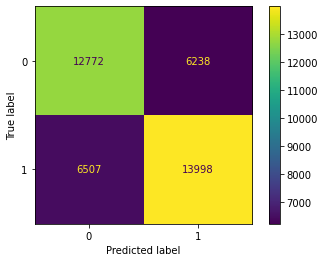

In [39]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_hat = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, y_prob)
# This is without threshold tuning
# We could tune the threshold to achieve greater classification accuracy
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)

print('Accuracy: ', accuracy)
print('ROC AUC: ', roc_auc)
print('F1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

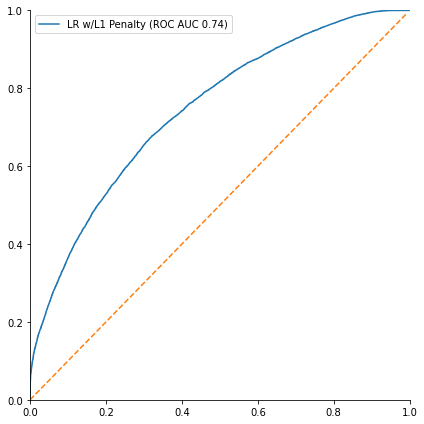

In [40]:
from sklearn.metrics import roc_curve, RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, y_prob)
noskill = np.arange(0, 1, 0.01)

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

ax.plot(fpr, tpr, label=f'LR w/L1 Penalty (ROC AUC {roc_auc:.2f})')
ax.plot(noskill, noskill, linestyle='dashed')
ax.legend()
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
fig.show()

In [41]:

coef_df = (pd.DataFrame({'feature':vectorizer.get_feature_names_out(), 
              'coef':clf.coef_[0],
              'abs_coef':np.abs(clf.coef_)[0]})
.sort_values('abs_coef', ascending=False))

print('Total Features', X_train.shape[1])
print('N Coefficients GT zero:', coef_df[coef_df.abs_coef > 0].shape[0])
print('Ratio of Coefficients GT zero:', coef_df[coef_df.abs_coef > 0].shape[0]/X_train.shape[1])

Total Features 14060
N Coefficients GT zero: 6370
Ratio of Coefficients GT zero: 0.45305832147937414


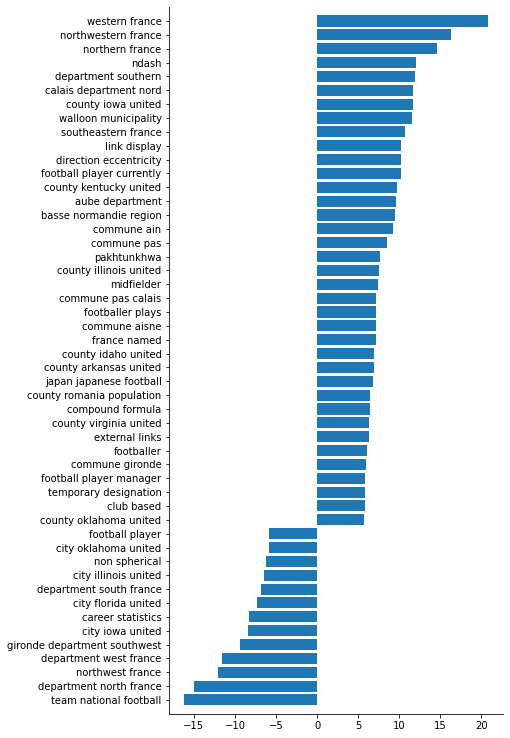

In [66]:
def plot_feature_importances(coef_df, n_features=50):
  plot_df = coef_df.head(n_features).sort_values('coef')

  x = plot_df['coef']
  y = plot_df['feature']

  plt.figure(figsize=(6, 13))
  plt.barh(y, x)

  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  plt.ylim((-1, max(range(len(y)))+1))

  plt.show()

plot_feature_importances(coef_df)
